# Usando _fastText_ para tareas de aprendizaje supervisado

### Parte 2 de 3 sobre fastText

### 03/07/2019

## 1: Repitamos lo que ya sabemos porque es gratis o "¿qué es el aprendizaje supervisado?"

A esta altura ya estamos relativamente habituados al concepto de clasificación. De todos modos, está bueno que lo contextualicemos bien para enmarcar adecuadamente esta reunión y la próxima. Lo que distingue al aprendizaje supervisado (clasificación) del aprendizaje no supervisado (_clustering_) es que mientras que en una tarea de _clustering_ tomamos un conjunto de observaciones con sus respectivas variables y utilizamos la estructura de esas variables para realizar una inferencia sobre nuestras observaciones, en una tarea de clasificación tenemos un conjunto de observaciones cuya estructura ya conocemos e intentamos seleccionar las variables que mejor den cuenta de ella con el propósito de predecir observaciones nuevas. 
En una tarea de _clustering_ estamos buscando una estructura desconocida sobre datos que ya conocemos, mientras que en la clasificación estamos tratando de generalizar una estructura conocida sobre datos desconocidos. La estructura está determinada por un conjunto de etiquetas (que no necesitan ser mutuamente exclusivas) correspondientes a cada observación.

Para todo caso de aprendizaje supervisado hay por lo menos dos etapas en el uso de los algoritmos: entrenamiento y prueba. Durante la fase de entrenamiento el modelo observa iterativamente los ejemplos de los datos de prueba y va ajustando sus parámetros en consecuencia. Esto es más o menos como decir que el modelo va construyendo un resumen de los grupos etiquetados. Y podemos estirar esa analogía, pensando en que, cuando hacemos un resumen, no queremos capturar la totalidad del texto, sino las regularidades más importantes. Si nosotros nos ajustamos demasiado al corpus de entrenamiento, vamos a estar haciendo _overfitting_. 

Al mismo tiempo, en un resumen a veces dejamos de lado información que estaba presente en el texto pero no era demasiado importante, o al menos no tenía demasiado protagonismo, y si necesitamos estudiar algo partiendo de ese resumen, varias veces nos vamos a encontrar con temas que estaban cubiertos en el texto original pero no en el resumen y no vamos a poder encararlos adecuadamente. Algo así podríamos suponer que ocurre con los clasificadores: podemos esperar que sean buenos para identificar las clases más representadas, pero que fallen a la hora de identificar elementos subrrepresentados en el corpus de entrenamiento. Eso es algo de lo que nos vamos a enterar en la fase de prueba, donde contrastamos las predicciones del modelo contra el etiquetado manual.

Dependiendo del tipo de clasificador, nosotros podemos obtener uno o dos de los siguientes tipos de _output_: podemos obtener una **etiqueta** o un **puntaje**. En el primer caso la interpretación es bastante sencilla, en términos de que consideramos que el algoritmo estimó que, de todas las clases posibles, la etiqueta (o las etiquetas) devueltas son las más probables. En el segundo caso lo que obtenemos es una combinación de puntajes correspondientes a cada una de las etiquetas posibles. Esto es fácilmente interpretable en términos de una etiqueta individual, ya que sencillamente se puede interpretar que la etiqueta correspondiente al documento es la que recibe un mayor puntaje, pero además nos da la posibilidad de tratar con clases subrrepresentadas, en términos de que aún si hay muy pocos documentos para los cuales el mayor de los puntajes sea el correspondiente a la etiqueta subrrepresentada, podemos tomar a la totalidad de los documentos y ordenarlos según su puntaje en esa clase y quedarnos con los **n** documentos con mayor valor como ejemplos de la clase. Otra utilidad de este _output_ es que, si tenemos varios clasificadores operando sobre un mismo documento, podemos operar sobre los puntajes para combinar las predicciones.



## 2: Entonces, ¿cómo aprende _fastText_?

Si hacemos un poco de memoria sobre la clase de Martín, vamos a recordar que las redes neuronales emplean básicamente dos tipos de funciones en el aprendizaje, costo y activación, y la diferencia entre uno y otro es el propósito: mientras que la función de costo es la que usamos para penalizar los errores de la red (_bad network!_) y es lo que se trata de optimizar en el aprendizaje, la función de activación es lo que determina si una neurona se activa, propagándose hacia la capa siguiente, o no. En _fastText_ podemos seleccionar cuatro tipos diferentes de funciones de costo: _softmax_, que es una generalización multivariada (cada palabra palabra sería una variable) de la función sigmoidea (que es lo que usaríamos por defecto), _hierarchical softmax_, que es una optimización de _softmax_ en la cual en vez de considerar que cada palabra del vocabulario es una variable de la función _softmax_, las palabras se representan en un árbol binario, donde la probabilidad de la palabra es la suma de las probabilidades de los caminos desde la palabra hasta la raíz del árbol, y la probabilidad de cada camino está determinada por una función logística en cada nodo. Aquí la idea es que es más fácil optimizar una función logística por nodo que una _softmax_ por palabra. Así, la complejidad de la optimización de la función de costo se reduce de $\mathcal{O}(n)$ a $\mathcal{O}(\log{}n)$. Otra posibilidad es _negative sampling_ (ns), que supone una simplificación en los términos de _softmax_ donde se trabaja con una distribución de ruido utilizando regresión logística para distinguir entre cada una de las palabras del _input_ y **n** palabras muestreadas como ruido.

Si bien estas funciones de costo son las que _fastText_ aplica para el aprendizaje de embeddings, el aprendizaje de las etiquetas de un modelo supervisado se lleva a cabo a través de una función _softmax_ jerárquica. Esto hace que la inferencia final sea una distribución de probabilidad sobre las clases del modelo. Sin embargo, para el caso de modelos supervisados, podemos utilizar una cuarta función de costo, _one versus all_, en la que se entrenan múltiples modelos binarios y el output de cada clase es la probabilidad que se le asigna según el modelo correspondiente a cada una.



## 3: OK, pero ¿cómo uso esto para sacar un modelo útil?

Hasta acá ya deberíamos tener una idea razonablemente buena sobre cómo funciona el entrenamiento. Al mismo tiempo, sabemos que podemos sacar métricas de _precision_ y _recall_ de _fastText_. Sin embargo, por un lado la API de _fastText_ no es demasiado amigable para comparar estas métricas entre modelos, y por el otro hay diferentes maneras de obtener estas métricas. A grandes rasgos, podemos pensar en una evaluación por _holdout_, donde dividimos nuestro _dataset_ en dos o tres conjuntos y empleamos uno para entrenar, otro para evaluar y realizar ajustes, y otro como prueba final (opcional), o en una evaluación por validación cruzada (_cross-validation_), que supone la generación de **k** particiones de nuestros datos y en el entrenamiento de **k** modelos, donde se entrena cada modelo sobre el total de los datos menos la partición **k**, que se emplea para evaluarlo. Así, las métricas finales son el resultado de promediar los valores de _precision_ y _recall_ obtenidos por cada modelo. 

El uso de uno u otro método de evaluación depende fuertemente de la situación de uso y de los datos disponibles para entrenar. Cuando poseemos una cantidad importante de datos de entrenamiento, o cuando queremos comparar modelos entrenados sobre diferentes conjuntos de variables, probablemente nos resulte más conveniente usar _holdout_. En cambio, si no tenemos una gran abundancia de datos o si queremos comparar diferentes parametrizaciones de un mismo tipo de modelo puede ser mejor usar validación cruzada. Un posible obstáculo para esto es que _fastText_ no posee ningún método implementado para facilitar estos procesos. Sin embargo, el conjunto de herramientas disponibles en la librería **sklearn** de Python sí tiene todas estas utilidades disponibles. En esta reunión vamos a usar _fastText_ pero a través del paquete **skift**, que encapsula los métodos nativos de los _bindings_ de _fastText_ para Python en una API idéntica a la de sklearn, lo cual permite emplear las herremientas de sklearn para el entrenamiento y la evaluación de modelos de _fastText_.

Veamos primero cómo entrenar un modelo usando skift.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import fastText as ft
import matplotlib.pyplot as plt
import seaborn as sns

from skift import FirstObjFtClassifier  # ¡Tuve que modificar la librería para que guarde en utf8!

In [2]:
data = pd.read_csv('../data/training_1.csv', sep = '\t')

stanceDict = {
    1: 'a favor',
    2: 'en contra',
    3: 'indecidible'
}

In [3]:
modelo_demo = FirstObjFtClassifier()
modelo_demo.fit(X = data[['texto']], y = data['stance'])

FirstObjFtClassifier()

Una de las primeras diferencias que podemos observar es que podemos realizar el entrenamiento desde un _data frame_ de pandas, y no necesitamos agregar un prefijo como "\_\_label\_\_" a las etiquetas, sino que basta con seleccionar la columna donde se encuentran.

Sin embargo, la posibilidad de incorporar elementos de sklearn nos posibilita el empleo de herramientas que antes no teníamos a nuestra disposición, por ejemplo, podemos hacer un _train-test split_ y usarlo para generar una matriz de confusión.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

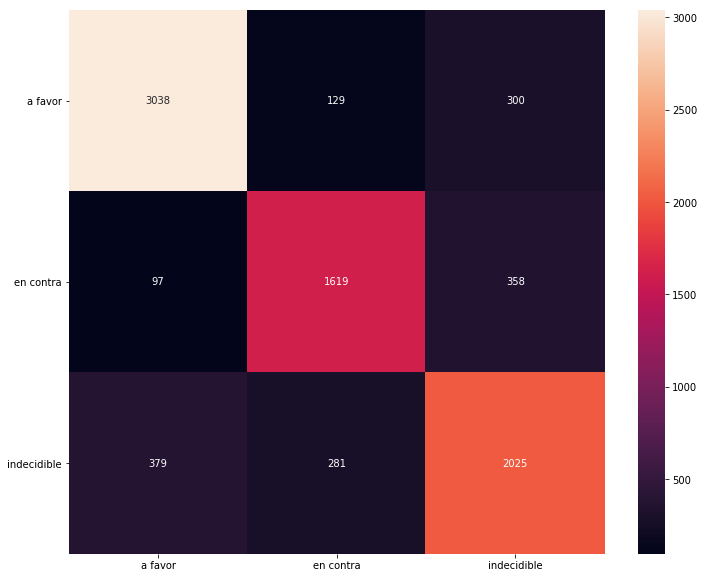

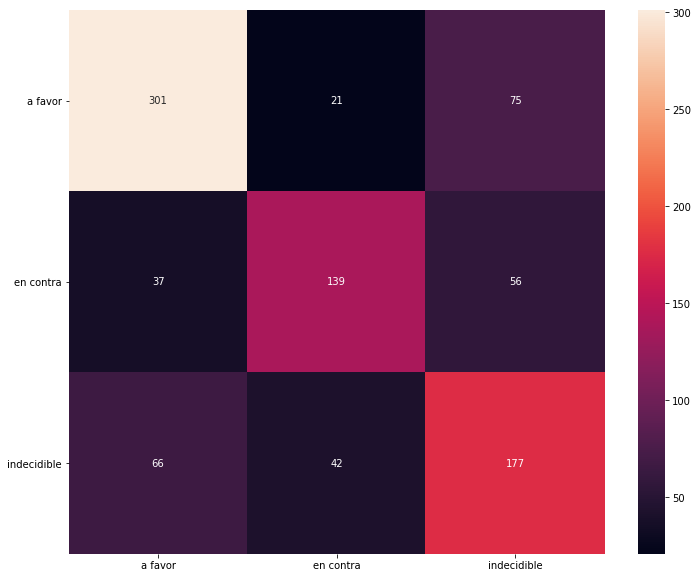

In [5]:
train, test = train_test_split(data, train_size = .9, test_size = .1)

modelo_holdout = FirstObjFtClassifier()
modelo_holdout.fit(X = train[['texto']], y = train['stance'])

train['pred'] = modelo_holdout.predict(train[['texto']])
train_matrix = confusion_matrix(train['stance'], train['pred'])

plt.figure(figsize = (12,10))
sns.heatmap(train_matrix, annot=True, fmt='.0f')
plt.xticks(np.arange(len(data.stance.unique())) + .5, map(lambda x: stanceDict[x], data.stance.unique()))
plt.yticks([.5, 1.5, 2.5], map(lambda x: stanceDict[x], data.stance.unique()), rotation = 0)
plt.show()


test['pred'] = modelo_holdout.predict(test[['texto']])
test_matrix = confusion_matrix(test['stance'], test['pred'])

plt.figure(figsize = (12,10))
sns.heatmap(test_matrix, annot=True, fmt='.0f')
plt.xticks(np.arange(len(data.stance.unique())) + .5, map(lambda x: stanceDict[x], data.stance.unique()))
plt.yticks([.5, 1.5, 2.5], map(lambda x: stanceDict[x], data.stance.unique()), rotation = 0)
plt.show()

También podemos aprovechar para consultar el puntaje global del modelo y las métricas que nos interesan de _precision_, _recall_ y f1.

In [6]:
print(modelo_holdout.score(test[['texto']], test['stance']), '\n')
print(classification_report(test['stance'], test['pred']))

0.675054704595186 

             precision    recall  f1-score   support

          1       0.75      0.76      0.75       397
          2       0.69      0.60      0.64       232
          3       0.57      0.62      0.60       285

avg / total       0.68      0.68      0.68       914



Si preferimos usar CV en lugar de _holdout_, podemos emplear la función _cross_\__validate_. Para eso lo que hacemos no es evaluar uno de los modelos que ya entrenamos sino indicar el tipo de modelo, las variables que debe contemplar, y cómo queremos que se efectúe la validación.

In [7]:
from sklearn.model_selection import cross_validate

modelo_CV = FirstObjFtClassifier()
output_CV = cross_validate(modelo_CV, data[['texto']], data['stance'], scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy'], cv = 10, return_train_score = True)
dataFrame_CV = pd.DataFrame(output_CV)

display(dataFrame_CV)
display(dataFrame_CV.agg('mean').reset_index(name = 'promedio'))

,fit_time,score_time,test_accuracy,test_f1_macro,test_precision_macro,test_recall_macro,train_accuracy,train_f1_macro,train_precision_macro,train_recall_macro
0,0.238708,0.049951,0.644809,0.632748,0.648319,0.648262,0.762553,0.746183,0.775937,0.767043
1,0.235297,0.053272,0.609836,0.604382,0.621217,0.608522,0.806809,0.803613,0.801187,0.810960
2,0.235312,0.049622,0.602186,0.596638,0.652086,0.606534,0.787964,0.789278,0.802104,0.794168
3,0.235215,0.050575,0.627322,0.618900,0.679224,0.619022,0.765714,0.770039,0.802981,0.776141
4,0.233709,0.053098,0.570022,0.569310,0.647028,0.588186,0.756382,0.762306,0.795073,0.771398
5,0.231722,0.051180,0.659737,0.660431,0.724527,0.663779,0.740336,0.746178,0.798302,0.750825
6,0.231357,0.050974,0.705367,0.700633,0.722157,0.701287,0.770998,0.775635,0.802842,0.783186
7,0.236473,0.047234,0.687842,0.678660,0.711592,0.676600,0.746688,0.751673,0.804070,0.755116
8,0.231449,0.052979,0.665936,0.667851,0.683946,0.674313,0.798104,0.797652,0.805915,0.803072
9,0.232325,0.053961,0.584885,0.589666,0.623308,0.593915,0.785584,0.788780,0.807514,0.797726


,index,promedio
0,fit_time,0.234157
1,score_time,0.051285
2,test_accuracy,0.635794
3,test_f1_macro,0.631922
4,test_precision_macro,0.671340
5,test_recall_macro,0.638042
6,train_accuracy,0.772113
7,train_f1_macro,0.773134
8,train_precision_macro,0.799592
9,train_recall_macro,0.780963


El _output_ de estos métodos está fuertemente influido por la cantidad de splits que se realicen, y pasa lo mismo con el desempeño: mientras menor sea la cantidad de _splits_ se van a entrenar menos modelos y sobre una cantidad de datos menor. A medida que aumenta la cantidad de splits la ejecución de la función se vuelve significativamente más lenta.

El uso de CV nos permite hacer una optimización por fuerza bruta de los parámetros de nuestro modelo. Nosotros podemos seleccionar los parámetros que deseamos variar, el rango en el que queremos que varíen, y comparar los puntajes de los modelos entrenados con distintas combinaciones de valores.

Por alguna razón (sospecho que tiene que ver con el modo en el que se encapsuló _fastText_ en skift) hay que definir explicitamente los valores del modelo sobre el cual queremos armar las comparaciones. El _modelo_\__ref_ de la celda de abajo está parametrizado con los valores por defecto de _fastText_. No se incluyen todos los valores porque pueden generar conflictos con sklearn. Quedan afuera _bucket_ y _thread_.

In [8]:
from sklearn.model_selection import GridSearchCV

modelo_ref = FirstObjFtClassifier(
    lr = 0.1,
    dim = 100,
    ws = 5,
    epoch = 5,
    minCount = 1,
    minCountLabel = 0,
    minn = 0,
    maxn = 0,
    neg = 5,
    wordNgrams = 1,
    loss = 'softmax',
    lrUpdateRate = 100,
    t = 1e-5
)

A partir de esto, podemos armar nuestra grilla de parámetros para comparar. Al hacer una operación de este tipo, es importante recordar que la cantidad de modelos que se entrena es bastante elevada. Para una grilla como la de abajo:

In [9]:
grilla = {
    'ws':[2,5,8],
    'wordNgrams':[1,2,3]
}

grilla2 = {
    'lr':np.arange(0, 1.1, .1),
    'epoch':np.arange(5,26,5),
    'minCount':[1,5,10],
    'minn':[0,1],
    'maxn':[1,2,3],
    'ws':[2,5,8],
    'wordNgrams':[1,2,3]
}

Se entrenan 3 x 3 modelos, multiplicados a su vez por la cantidad de _splits_ de CV. Para 5 splits esto equivale a entrenar 90 modelos, así que mantengan eso en mente al usar esta metodología.

In [10]:
comparaciones = GridSearchCV(modelo_ref, grilla, cv = 5, return_train_score=True)
comparaciones.fit(X = data[['texto']], y = data['stance'])

GridSearchCV(cv=5, error_score='raise',
       estimator=FirstObjFtClassifier(dim=100, epoch=5, loss='softmax', lr=0.1,
           lrUpdateRate=100, maxn=0, minCount=1, minCountLabel=0, minn=0,
           neg=5, t=1e-05, wordNgrams=1, ws=5),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'wordNgrams': [1, 2, 3], 'ws': [2, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [11]:
resultados = (
    pd.DataFrame(comparaciones.cv_results_)
    .drop(
        ['params'] + ['split{}_test_score'.format(x) for x in range(5)] + ['split{}_train_score'.format(x) for x in range(5)]
        , axis = 1
    )
    .sort_values('rank_test_score')
    .reset_index(drop = True)
)

display(resultados)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_wordNgrams,param_ws,rank_test_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.234185,0.027615,0.616083,0.781729,1,2,1,0.013226,0.001000,0.038488,0.015202
1,0.225994,0.027356,0.614004,0.777899,1,8,2,0.000901,0.001339,0.034518,0.027432
2,0.226109,0.026914,0.608753,0.763677,3,5,3,0.000506,0.000382,0.039483,0.019220
3,0.227626,0.027341,0.603501,0.764278,2,2,4,0.002613,0.000996,0.046644,0.010293
4,0.226301,0.027165,0.600766,0.764032,3,2,5,0.000522,0.001379,0.046550,0.034276
5,0.226432,0.026749,0.598578,0.755060,2,5,6,0.000925,0.000271,0.056020,0.028445
6,0.226099,0.028148,0.597155,0.751340,1,5,7,0.000612,0.000825,0.043629,0.015929
7,0.233314,0.026887,0.592232,0.748632,2,8,8,0.014512,0.000375,0.058688,0.017187
8,0.226417,0.028370,0.590810,0.750574,3,8,9,0.000738,0.001564,0.054516,0.015050


Después de este proceso, podemos usar el atributo _best_\__params_\_ de las comparaciones para obtener los valores de los parámetros que dieron los mejores resultados y entrenar un modelo completo con ellos

In [12]:
modelo_final = FirstObjFtClassifier(**comparaciones.best_params_)
modelo_final.fit(X = train[['texto']], y = train['stance'])

FirstObjFtClassifier(wordNgrams=1, ws=2)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

/home/federico/reportesFrutales/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 4: Combinando modelos

Hasta acá estamos considerando sólo el uso de modelos de _fastText_, pero podríamos estar en una situación en la que el corpus con el cual estamos trabajando incorpore otro tipo de información que nos puede resultar útil para clasificar nuestros datos. El caso que voy a demostrar ahora implica entrenar un par de modelos más sobre datos parecidos a los que ya teníamos pero con otras variables. Hay distintos tipos de técnicas para combinar los resultados de varios modelos para obtener una única clasificación final, y no nos vamos a meter con eso acá. Lo importante es que la función para agregar modelos en sklearn necesita que todos ellos se entrenen sobre los mismos datos y las mismas variables, así que no sirve para la situación que tenemos ahora. En lugar de eso, lo que está implementado acá abajo es cómo sumar los casos en los que un modelo entrega como _output_ una distribución sobre las etiquetas para quedarte con la que tenga un valor mayor.

El dataset está etiquetado según el origen de los textos en una red de usuarios (variable categórica) y tiene una columna con la cantidad de tokens en cada texto (variable numérica). Para poder parametrizar los otros modelos que vamos a usar (regresión logística y _random forest_) necesitamos usar una codificación _one-hot_ con la variable categórica.

In [14]:
frame = pd.read_csv('../data/training_1_expandido.csv', sep = '\t')
dummy_frame = pd.get_dummies(frame[['stance', 'com_tag', 'cant_palabras']])
dummy_frame['texto'] = frame['texto']

stack_train, stack_test = train_test_split(dummy_frame, train_size = .9, test_size = .1)

In [15]:
modelo_stack = FirstObjFtClassifier()
modelo_stack.fit(X = stack_train[['texto']], y = stack_train['stance'])

FirstObjFtClassifier()

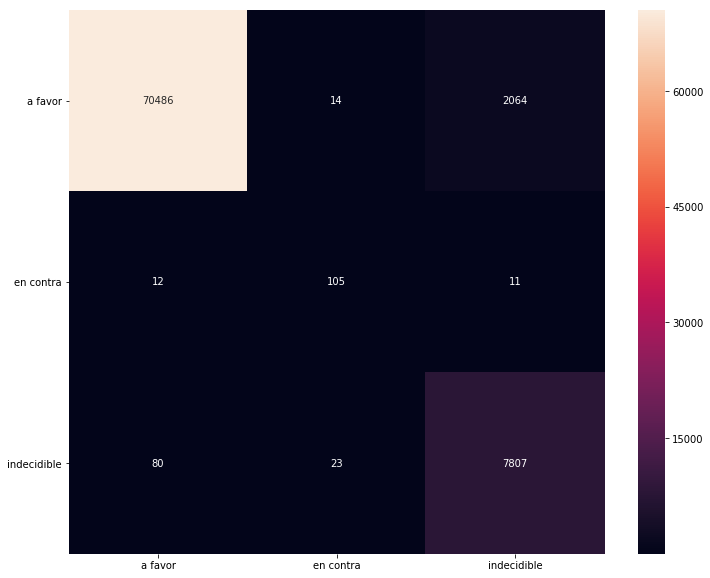

In [16]:
pred_ft = modelo_stack.predict(stack_test[['texto']])

stack_ft_matrix = confusion_matrix(stack_test['stance'], pred_ft)

plt.figure(figsize = (12,10))
sns.heatmap(stack_ft_matrix, annot=True, fmt='.0f')
plt.xticks(np.arange(len(data.stance.unique())) + .5, map(lambda x: stanceDict[x], data.stance.unique()))
plt.yticks([.5, 1.5, 2.5], map(lambda x: stanceDict[x], data.stance.unique()), rotation = 0)
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [18]:
stance_array = np.array(stack_train.stance)

train_others = np.array(stack_train.drop(['stance','texto'], axis = 1))

cols = list(dummy_frame.columns)


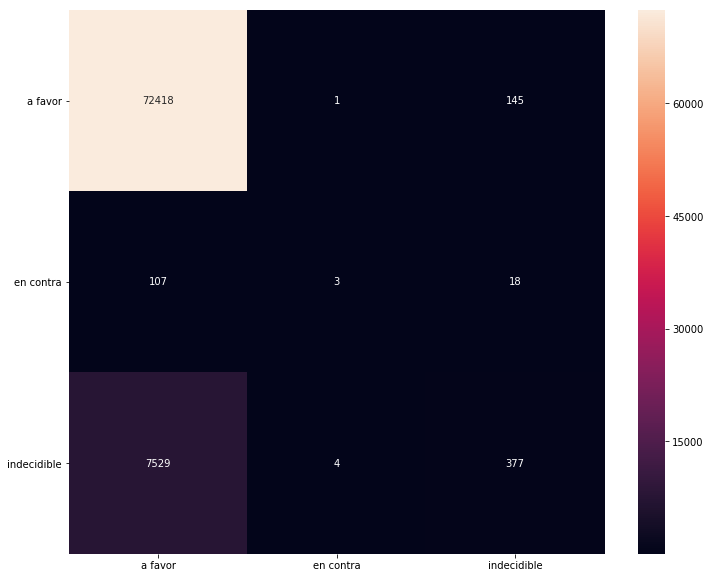

In [19]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=1)
lr.fit(train_others, stance_array)

pred_lr = lr.predict(np.array(stack_test.drop(['stance','texto'], axis = 1)))

stack_lr_matrix = confusion_matrix(stack_test['stance'], pred_lr)

plt.figure(figsize = (12,10))
sns.heatmap(stack_lr_matrix, annot=True, fmt='.0f')
plt.xticks(np.arange(len(data.stance.unique())) + .5, map(lambda x: stanceDict[x], data.stance.unique()))
plt.yticks([.5, 1.5, 2.5], map(lambda x: stanceDict[x], data.stance.unique()), rotation = 0)
plt.show()

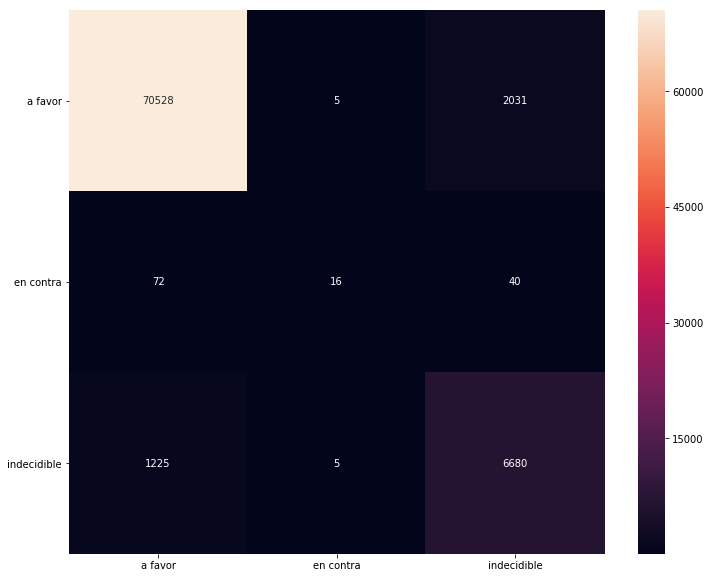

In [20]:
rf = RandomForestClassifier()
rf.fit(train_others, stance_array)

pred_rf = rf.predict(np.array(stack_test.drop(['stance','texto'], axis = 1)))

stack_rf_matrix = confusion_matrix(stack_test['stance'], pred_rf)

plt.figure(figsize = (12,10))
sns.heatmap(stack_rf_matrix, annot=True, fmt='.0f')
plt.xticks(np.arange(len(data.stance.unique())) + .5, map(lambda x: stanceDict[x], data.stance.unique()))
plt.yticks([.5, 1.5, 2.5], map(lambda x: stanceDict[x], data.stance.unique()), rotation = 0)
plt.show()

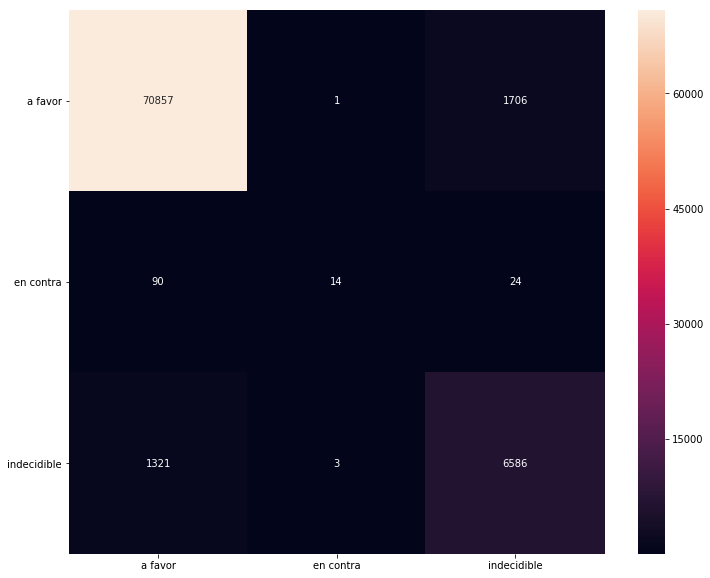

In [21]:
frem = pd.DataFrame(
    lr.predict_proba(np.array(np.array(stack_test.drop(['stance','texto'], axis = 1)))) + 
    rf.predict_proba(np.array(stack_test.drop(['stance','texto'], axis = 1))) + 
    modelo_stack.predict_proba(stack_test[['texto']]), columns = [1,2,3]
)
preds = frem.unstack().reset_index(name = 'prob').groupby('level_1').prob.max().reset_index().merge(frem.unstack().reset_index(name = 'prob'), how = 'left').rename({'level_0':'pred'}, axis = 1)

matrix = confusion_matrix(stack_test['stance'], preds['pred'])
plt.figure(figsize = (12,10))
sns.heatmap(matrix, annot=True, fmt='.0f')
plt.xticks(np.arange(len(data.stance.unique())) + .5, map(lambda x: stanceDict[x], data.stance.unique()))
plt.yticks([.5, 1.5, 2.5], map(lambda x: stanceDict[x], data.stance.unique()), rotation = 0)
plt.show()